In [7]:
import xmltodict


def read_in_xml_data_as_dict(xml_file_path):
    """
    Reads in an XML doc as a dict
    """
    # Read the XML file
    with open(xml_file_path, "r") as file:
        xml_content = file.read()

    # Parse the XML content
    data = xmltodict.parse(xml_content)
    return data

xml_file_path = "/Users/mikey/Library/Mobile Documents/com~apple~CloudDocs/Code/roux_class_files/CS7180/Projects/project2/Shadow-Removal-with-Illumination-Sprectral-Direction/new_annotator_dev/test_images/annotations.xml"

data = read_in_xml_data_as_dict(xml_file_path)
data

{'annotations': {'image': [{'@name': 'walsh_john_075.tif',
    '@target_directory': 'new_annotator_dev/test_images/processed/high_quality',
    '@patch_size': '(1, 1)',
    '@anchor_point': '[10.8 10.8 10.8]',
    'click': [{'@id': '1',
      'lit': {'@row': '408', '@col': '904'},
      'shadow': {'@row': '436', '@col': '803'}},
     {'@id': '2',
      'lit': {'@row': '819', '@col': '1037'},
      'shadow': {'@row': '935', '@col': '998'}}]},
   {'@name': 'walsh_john_061.tif',
    '@target_directory': 'new_annotator_dev/test_images/processed/high_quality',
    '@patch_size': '(1, 1)',
    '@anchor_point': '[10.8 10.8 10.8]',
    'click': {'@id': '1',
     'lit': {'@row': '633', '@col': '413'},
     'shadow': {'@row': '651', '@col': '658'}}},
   {'@name': 'wenqing_fan_064.tif',
    '@target_directory': 'new_annotator_dev/test_images/processed/high_quality',
    '@patch_size': '(1, 1)',
    '@anchor_point': '[10.8 10.8 10.8]',
    'click': {'@id': '1',
     'lit': {'@row': '938', '@col': 

In [8]:
def display_nested_dict(d, indent=0):
    """
    Recursively print keys and values of a nested dictionary.
    
    Parameters:
    - d (dict): The dictionary to display.
    - indent (int): The current indentation level.
    """
    for key, value in d.items():
        print("  " * indent + str(key) + ":")
        if isinstance(value, dict):
            # If the value is a dictionary, call the function recursively
            display_nested_dict(value, indent + 1)
        elif isinstance(value, list):
            # If the value is a list, iterate through its elements
            for i, item in enumerate(value):
                print("  " * (indent + 1) + f"[{i}]:")
                if isinstance(item, dict):
                    display_nested_dict(item, indent + 2)
                else:
                    print("  " * (indent + 2) + str(item))
        else:
            # Otherwise, print the value
            print("  " * (indent + 1) + str(value))


display_nested_dict(data)

annotations:
  image:
    [0]:
      @name:
        walsh_john_075.tif
      @target_directory:
        new_annotator_dev/test_images/processed/high_quality
      @patch_size:
        (1, 1)
      @anchor_point:
        [10.8 10.8 10.8]
      click:
        [0]:
          @id:
            1
          lit:
            @row:
              408
            @col:
              904
          shadow:
            @row:
              436
            @col:
              803
        [1]:
          @id:
            2
          lit:
            @row:
              819
            @col:
              1037
          shadow:
            @row:
              935
            @col:
              998
    [1]:
      @name:
        walsh_john_061.tif
      @target_directory:
        new_annotator_dev/test_images/processed/high_quality
      @patch_size:
        (1, 1)
      @anchor_point:
        [10.8 10.8 10.8]
      click:
        @id:
          1
        lit:
          @row:
            633
          @co

## Chromaticity Spaces and Illuminate Spectral Direction  
This notebook implements various aspects of Maxwell's RoadVision & LightBrush Papers

___ 
### Packages

In [1]:
import cv2  
import pandas as pd  
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from pathlib import Path

___
### Set Up Paths

In [2]:
HOME = Path.cwd()
PATH_TO_DATA_FOLDER = HOME / "data" / "folder_8" / "done"
PATH_TO_ANNOTATIONS_CSV =  HOME / "data" / "folder_8"
FIGS_PATH = HOME / "figs"

### Helper Functions

In [3]:
def display_image(image:np.array, title:str) -> None:
    """ 
    Displays an image
    """
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show();

def convert_img_to_rg_chromaticity(img:np.array, epsilon:float = 1e-10) -> np.array:
    """  
    Generates rg chromaticity image from a RGB image
    """
    # Compute the sum of pixels
    rbg_sum = img.sum(axis = 2, keepdims = True)

    # Divide each channel by pixel sum
    standard_chromaticity = img / (rbg_sum + epsilon)

    # Extract the r and g channels
    r_channel = standard_chromaticity[:, :, 0]
    g_channel = standard_chromaticity[:, :, 1]

    # Add a blue channel of zeros
    chromaticity_image = np.stack((r_channel, g_channel, np.zeros_like(r_channel)), axis = 2)
    
    return chromaticity_image

def get_lit_shadow_pixel_coordinates(image_annotations:pd.DataFrame, image_file_name:str) -> tuple:
    """  
    Extracts the lit and shadow pixel locations from the annoations df.
    Note: filename has to be set as the index for annotation df
    """
    # Extract annotations for image of interest
    image_annotations = image_annotations.loc[image_file_name]

    # Extract lit and shadow pixels
    lit_pixels = [
        (image_annotations[f"lit_row{i}"], image_annotations[f"lit_col{i}"])
        for i in range(1, 7)
    ]
    shadow_pixels = [
        (image_annotations[f"shad_row{i}"], image_annotations[f"shad_col{i}"])
        for i in range(1, 7)
    ]
    return lit_pixels, shadow_pixels

def inspect_annotations(img:np.array, lit_pixels:list, shadow_pixels:list) -> None:
    """  
    Displays the image with lit and shadow pixels highlighted
    """
    fig, ax = plt.subplots(figsize = (7, 12))
    ax.imshow(img)

    # Add circles around lit pixels
    for (y, x) in lit_pixels:
        circle = patches.Circle((x, y), radius=5, edgecolor='yellow', facecolor='none', linewidth=1, label='Lit Pixel')
        ax.add_patch(circle)

    # Add circles arond the shadow pixels
    for (y, x) in shadow_pixels:
        circle = patches.Circle((x, y), radius=5, edgecolor='red', facecolor='none', linewidth=1, label='Shadow Pixel')
        ax.add_patch(circle)

    # Add lines between points
    for (y1, x1), (y2, x2) in zip(lit_pixels, shadow_pixels):
        ax.plot([x1, x2], [y1, y2], linestyle='--', color='white', linewidth=1)

    # Add the legend
    handles = [
        patches.Patch(color='yellow', label='Lit Pixel'),
        patches.Patch(color='red', label='Shadow Pixel')
    ]
    plt.legend(handles = handles)
    plt.axis('off')
    plt.show()

def plot_isd_vector_3D(mean_isd:np.array) -> None:
    """  
    Displays the mean ISD vector
    """
    # Set up 3D fig
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the ISD vector
    ax.quiver(0, 0, 0, mean_isd[0], mean_isd[1], mean_isd[2], color='r', arrow_length_ratio=0.3)

    # Set limits for the axes
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.set_zlim([-2, 2])

    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z');

def plot_plane_orthogonal_to_isd(mean_isd:np.array, original_img:np.array, img:np.array = None, projection:np.array = None) -> None:
    """
    Displays the plane orthogonal to the ISD vector.
    Can also display img points and projected points
    """
    # Set up color map
    colors = original_img.reshape(-1, 3) / 255.0

    # Anchor point
    anchor_point = np.array([10.8, 10.8, 10.8])

    # Set up the figure and 3D axes
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111, projection = '3d')

    # Plot the vector using mean_isd
    ax.quiver(10.8, 10.8, 10.8, mean_isd[0], mean_isd[1], mean_isd[2], color='r', arrow_length_ratio=0.3, label = "ISD")

    # Create grid to plpt
    xx, yy = np.meshgrid(np.linspace(5, 15, 10), np.linspace(5, 15, 10))

    # Compute the corresponding z values for the plane
    # Plane equation: mean_isd[0]*x + mean_isd[1]*y + mean_isd[2]*z = 0
    # Solve for z: z = -(mean_isd[0]*x + mean_isd[1]*y) / mean_isd[2]
    zz = (-mean_isd[0]*(xx - anchor_point[0]) - mean_isd[1]*(yy - anchor_point[1])) / mean_isd[2] + anchor_point[2]

    # Plot the plane
    ax.plot_surface(xx, yy, zz, alpha = 0.5, color = 'cyan', label = "Plane Orthogonal to ISD")

    # Add the image points
    if img is not None:
            # Plot the orginal points
            ax.scatter(img[:, :, 0], img[:, :, 1], img[:, :, 2], color = "b", alpha = 0.1, s = 1, label = 'Original Points')
    
    # Add the projection points
    if projection is not None:
            # Plot the projection points
            ax.scatter(projection[:, :, 0], projection[:, :, 1], projection[:, :, 2], color = "g", alpha = 0.1, s = 1, label = 'Projected Points')
    
    # Set the limits
    ax.set_xlim([0, 15])
    ax.set_ylim([0, 15])
    ax.set_zlim([0, 15])

    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.legend()
    plt.show()

___
### Parameters

In [4]:
img_file =  "wenqing_fan_078.tif" # "wenqing_fan_099.tif" #"tang_yilin_065.tif" #"wenqing_fan_078.tif" # "wenqing_fan_078.tif" #"wenqing_fan_0101.tif" # "walsh_john_035.tif" 
annotations_csv_file = "annotation_folder_8.csv"
epsilon = 1e-10 # to be used to avoid dividing by zero

___ 
### Read In Test Image

In [5]:
img = cv2.imread(str(PATH_TO_DATA_FOLDER) + "/" + img_file, cv2.IMREAD_UNCHANGED)
img_2 = cv2.imread(str(PATH_TO_DATA_FOLDER) + "/" + img_file)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [6]:
#display_image(img_2, "Original")

In [7]:
img.dtype

dtype('uint16')

In [8]:
img = img.astype(np.float32)

In [9]:
img.shape

(1024, 1533, 3)

In [10]:
log_img = np.zeros_like(img)
log_img[img != 0] = np.log(img[img != 0])
log_img.shape

(1024, 1533, 3)

In [11]:
print(f"Max Log Value: {log_img.max()}")
print(f"Min Log Value: {log_img.min()}")

Max Log Value: 11.090339660644531
Min Log Value: 0.0


In [12]:
unique_values, counts = np.unique(log_img, return_counts = True)

In [13]:
len(unique_values)

63930

In [14]:
log_img_display = log_img.copy()
log_img_display = log_img_display * 255 / np.log(65535)
log_img_display = log_img_display.astype(np.uint8)
log_img_display.dtype

dtype('uint8')

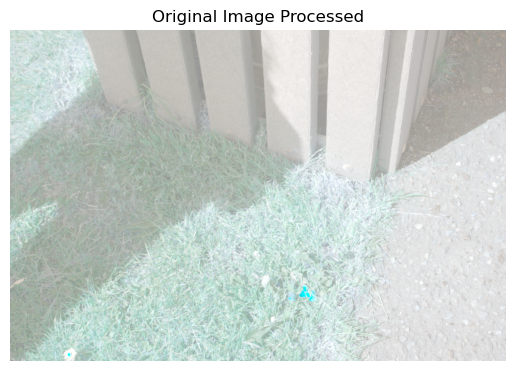

In [15]:
display_image(log_img_display, "Original Image Processed")

___
### Estimate Illuminate Spectral Direction  
This requires lit and shadow pixels

___ 
### Read In CSV of Lit & Shadowed Pixels

In [5]:
annotations_df = pd.read_csv(str(PATH_TO_ANNOTATIONS_CSV) + "/" + annotations_csv_file, index_col = "filename")
annotations_df


,lit_row1,lit_col1,shad_row1,shad_col1,lit_row2,lit_col2,shad_row2,shad_col2,lit_row3,lit_col3,...,shad_row4,shad_col4,lit_row5,lit_col5,shad_row5,shad_col5,lit_row6,lit_col6,shad_row6,shad_col6
filename,,,,,,,,,,,,,,,,,,,,,
walsh_john_001.tif,682,395,649,485,693,433,664,513,737,461,...,683,709,732,710,688,759,702,338,659,429
walsh_john_015.tif,788,317,764,385,291,166,282,230,348,168,...,695,330,898,413,879,451,446,814,438,881
wenqing_fan_010.tif,670,156,684,235,709,142,745,195,754,112,...,741,668,650,580,650,675,477,635,481,748
wenqing_fan_004.tif,927,861,802,789,920,998,808,838,363,916,...,395,959,365,1036,407,1004,155,894,221,606
wenqing_fan_038.tif,692,400,599,404,708,463,570,465,724,537,...,557,648,741,346,765,191,689,611,635,619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tang_yilin_063.tif,643,797,644,838,654,781,662,828,862,1117,...,828,604,763,371,784,332,621,768,629,861
walsh_john_018.tif,628,726,507,743,635,747,521,747,781,246,...,802,58,796,241,770,61,636,731,516,728
walsh_john_030.tif,232,572,509,584,250,720,495,745,316,851,...,367,929,681,635,739,448,778,638,804,516


In [6]:
# Check for duplicate indices in the DataFrame
duplicates = annotations_df.index.duplicated()

# If there are any duplicates, this will return True
has_duplicates = duplicates.any()

# Display the indices that are duplicated
duplicate_indices = annotations_df.index[duplicates]

print(f"Are there duplicate indices? {has_duplicates}")
if has_duplicates:
    print("Duplicate indices found:")
    print(duplicate_indices)


Are there duplicate indices? False


In [7]:
import os

# Count the number of files
num_files = sum([len(files) for _, _, files in os.walk(PATH_TO_DATA_FOLDER)])

print(f"Number of files: {num_files}")

Number of files: 258


### Get Pixel Coordinates  
This will extract the lit and shadow pixel coordinates from the annotations csv

In [ ]:
lit_pixels, shadow_pixels = get_lit_shadow_pixel_coordinates(annotations_df, img_file)

print(f"Lit pixels: {lit_pixels}")
print(f"Shadow Pixels: {shadow_pixels}")

Lit pixels: [(245, 894), (207, 860), (117, 894), (605, 726), (580, 775), (148, 1067)]
Shadow Pixels: [(324, 843), (290, 828), (333, 825), (511, 701), (468, 698), (149, 689)]


### Inspect the Annotations

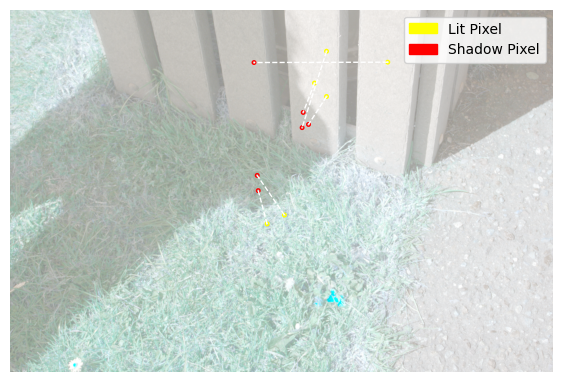

In [ ]:
inspect_annotations(log_img_display, lit_pixels, shadow_pixels)

___
### Compute the ISD  
This is from 4.1 of Lightbrush:  

4.1 Base Constraints and Linear System Representation
4.1.1 Illumination Spectral Direction. The only required user input
is an estimate of the illumination spectral direction. The ISD
defines the log chromaticity space for the log-chromaticity clustering
step. While automated schemes for detecting the ISD are
possible, we opt to allow simple user control. Lightbrush includes a
lit-dark pair tool that consists of two linked squares (Figure 4(a)).
The user places one square in a lit area of a material and the other
square in a shadowed area of the same material. The system uses
the average value under each block to estimate the ISD. If the user
specifies multiple lit-dark pairs, they can tell Lightbrush to average
the estimated ISDs or use a local adaptation scheme to deal with
changing illumination conditions within the scene.

### Check Lit ~ Shadow Pixel Difference

Ensure that the difference is greater than $0.3$ accorss all channels

In [ ]:
# Iterate over the pairs
lit_pixel_values = []
shadow_pixel_values = []
for (lit_pix, shadow_pix) in zip(lit_pixels, shadow_pixels):

    # Get the pixel values
    lit_pixel = log_img[lit_pix[0], lit_pix[1]]
    shadow_pixel = log_img[shadow_pix[0], shadow_pix[1]]
    lit_pixel_values.append(lit_pixel)
    shadow_pixel_values.append(shadow_pixel)

lit_pixel_values = np.array(lit_pixel_values)
shadow_pixel_values = np.array(shadow_pixel_values)

assert np.all((lit_pixel_values - shadow_pixel_values) > 0.3)
print("Assertion Passed")

Assertion Passed


### Compute the ISD ~ Per Pair and Mean

In [ ]:
# Define neutral ISD; RoadVision
neutral_isd = np.array([0.577, 0.577, 0.577]) 

# Container ofr ISDs
isd_list = []

# Iterate over the pairs
for (lit_pix, shadow_pix) in zip(lit_pixels, shadow_pixels):

    # Get the pixel values
    lit_pixel = log_img[lit_pix[0], lit_pix[1]]
    shadow_pixel = log_img[shadow_pix[0], shadow_pix[1]]

    # Compute and store the ISD
    isd = lit_pixel - shadow_pixel
    isd = isd / np.linalg.norm(isd)
    isd_list.append(isd)

print(f"Illuminate Spectral Direction for Each Pair:")
for isd in isd_list:
    print(f"\t{isd}")

# Compute the mean ISD, Bruce mentions this in LightBrush
mean_isd = np.mean(np.array(isd_list), axis = 0)
dot_isd_neutral_isd = np.dot(mean_isd, neutral_isd)
print()
print(f"Mean ISD:\n\t {mean_isd}")
print()
print(f'Dot product of ISD and neutral ISD: \n\t {dot_isd_neutral_isd}')

assert dot_isd_neutral_isd < 0.9985
print(f"Assertion Passed")

Illuminate Spectral Direction for Each Pair:
	[0.59725165 0.56063026 0.5735714 ]
	[0.5902391  0.55350906 0.587576  ]
	[0.6070237 0.5500632 0.5735439]
	[0.4491859  0.5786754  0.68071055]
	[0.50375825 0.6003937  0.6210918 ]
	[0.5734955  0.5448843  0.61172205]

Mean ISD:
	 [0.5534923 0.5646927 0.608036 ]

Dot product of ISD and neutral ISD: 
	 0.9960294970273971
Assertion Passed


### Inspect ISD

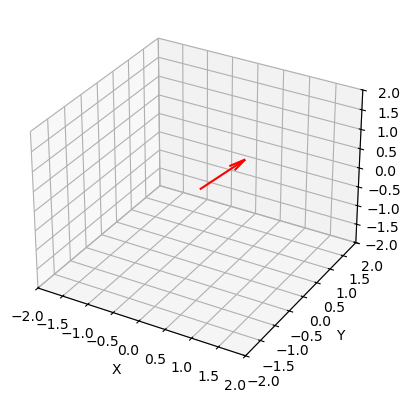

In [ ]:
plot_isd_vector_3D(mean_isd)

### Inspect A Plane Orthogonal to ISD

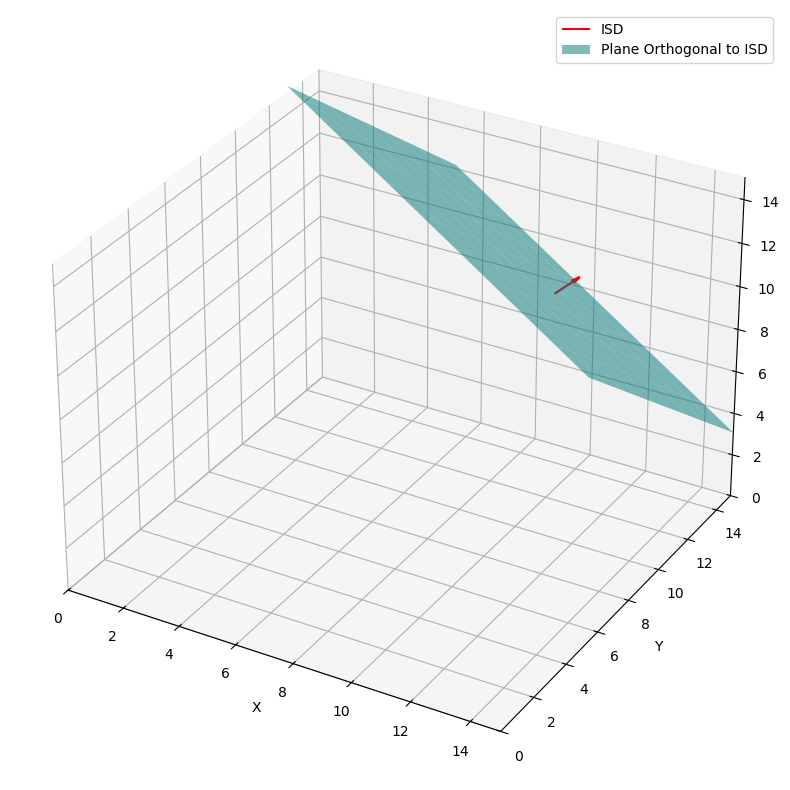

In [ ]:
plot_plane_orthogonal_to_isd(mean_isd = mean_isd, original_img = img)

### Show Image Points In Relation to ISD 

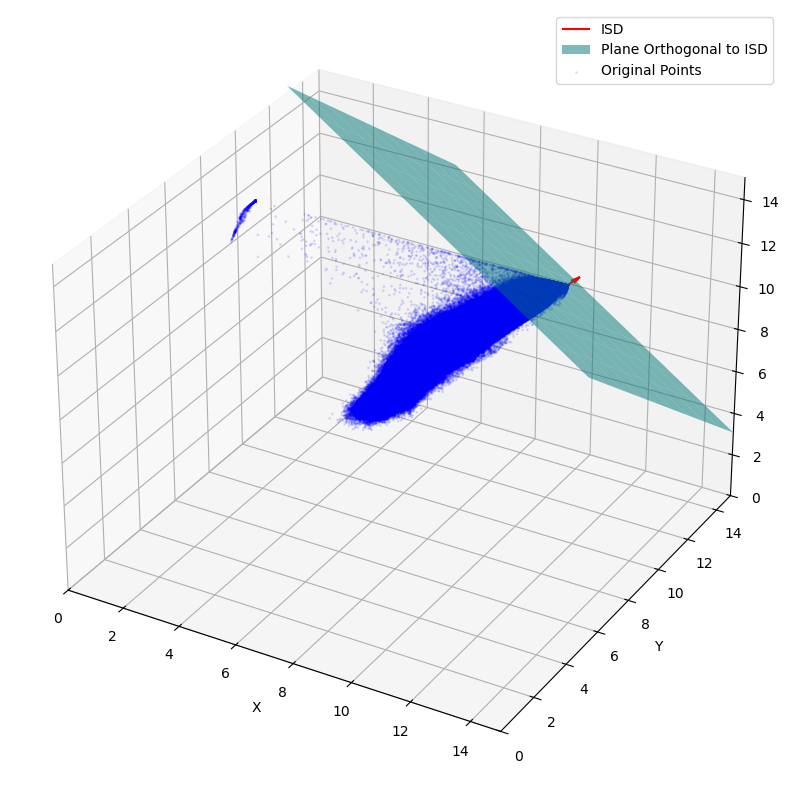

In [ ]:
plot_plane_orthogonal_to_isd(mean_isd, original_img = (img / 65535), img = log_img)

### Project Log RGB onto Plane Orthogonal to ISD  
$$img\_projected_{i,j} = \log(IMG)_{i,j} - \bigg(\frac{\vec{ISD} \cdot (\log(IMG)_{i,j} - \vec{A})}{\vec{ISD} \cdot \vec{ISD}}\bigg) \cdot \vec{ISD}$$  

This equation projects the pixels to the plane orothogonal to ISD, i.e., 2D chromaticity

In [ ]:
def project_to_plane(log_rgb: np.array, mean_isd: np.array, anchor_point: np.array) -> np.array:
    """
    Projects the log RGB values onto a plane defined by a normal vector,
    with the plane anchored at the given anchor point.

    Parameters:
    -----------
    log_rgb : np.array
        Log-transformed RGB values with shape (H, W, 3).
    mean_isd : np.array
        The normal vector of the plane.
    anchor_point : np.array
        The point where the plane is anchored in log space.

    Returns:
    --------
    projected_rgb : np.array
        Log RGB values projected onto the plane.
    """
    # Shift the log RGB values relative to the anchor point
    shifted_log_rgb = log_rgb - anchor_point

    # Normalize the isd vector
    norm_isd = mean_isd / np.linalg.norm(mean_isd)

    # Perform the projection for each pixel
    #projection = np.einsum('ijk,k->ij', shifted_log_rgb, mean_isd)[:, :, np.newaxis] * mean_isd

    # Computes a dot product along the last dimension of the RGB pixel data with the ISD vector
    # where, i: Height dimension, j: Width dimension, k: RGB channels (3 channels)
    # sum over the shared k dimension: RGB and ISD
    # contracts the k dimension, resulting array will have shape (H, W), indicated by ij in the output.
    dot_product = np.einsum('ijk,k->ij', shifted_log_rgb, norm_isd)

    # Reshape the dot product to (H, W, 1) for broadcasting
    dot_product_reshaped = dot_product[:, :, np.newaxis]

    # Multiply with the ISD vector to get the projected RGB values
    projection = dot_product_reshaped * norm_isd

    # Subtract the projection from the shifted values to get plane-projected values
    projected_rgb = shifted_log_rgb - projection

    # Shift the values back by adding the anchor point
    projected_rgb += anchor_point

    return projected_rgb

projected_log_rgb = project_to_plane(log_img, isd, np.full(3, 10.8))

In [ ]:
# Anchor vector
anchor = np.array([10.8, 10.8, 10.8])

# Chromaticity image container
img_shape = log_img.shape
projected_log_img = np.zeros(img_shape)

# Compute projection with proper reference to the anchor
checker = 0
for i in range(log_img.shape[0]):
    for j in range(log_img.shape[1]):
        
        # Compute difference from anchor
        diff_from_anchor = log_img[i, j] - anchor

        # Compute the dot product of the difference and ISD
        dot_diff_from_anchor_isd = np.dot(diff_from_anchor, isd)

        # Compute the parallel component (along ISD direction)
        parallel_component = dot_diff_from_anchor_isd * isd

        # Compute the orthogonal component relative to the anchor
        orthogonal_component = diff_from_anchor - parallel_component

        # Verify orthogonality - dot product of orthogonal_component and ISD should be 0
        orthogonality_check = np.dot(orthogonal_component, isd)

        # Update projected img
        projected_log_img[i, j] = orthogonal_component + anchor

        # Check the first 10 computations; orthogonality
        if checker < 10:
            print(f"log_img[{i}, {j}]: {log_img[i, j]}")
            print(f"Parallel component: {parallel_component}")
            print(f"Orthogonal component: {orthogonal_component}")
            print(f"Dot product (orthogonal component, ISD): {orthogonality_check}\n")
            checker += 1

log_img[0, 0]: [8.745603 9.478457 9.246865]
Parallel component: [-1.633523 -1.552028 -1.742406]
Orthogonal component: [-0.4208744   0.23048539  0.18927128]
Dot product (orthogonal component, ISD): -2.8577527453777187e-07

log_img[0, 1]: [8.729559 9.394993 9.217316]
Parallel component: [-1.675248  -1.5916715 -1.7869123]
Orthogonal component: [-0.39519303  0.1866643   0.204228  ]
Dot product (orthogonal component, ISD): -2.0926104847163409e-07

log_img[0, 2]: [8.861067  9.5294485 9.296243 ]
Parallel component: [-1.5622903 -1.484349  -1.6664253]
Orthogonal component: [-0.37664287  0.21379752  0.16266806]
Dot product (orthogonal component, ISD): -4.3601363850953824e-07

log_img[0, 3]: [8.968779 9.722205 9.456732]
Parallel component: [-1.4103272 -1.3399673 -1.5043331]
Orthogonal component: [-0.42089419  0.26217241  0.16106493]
Dot product (orthogonal component, ISD): -3.1870839032777333e-07

log_img[0, 4]: [9.080004 9.771098 9.654321]
Parallel component: [-1.289149  -1.2248346 -1.3750777]
O

In [ ]:
# Anchor vector
anchor = np.array([10.8, 10.8, 10.8])

# Chromaticity image container
img_shape = log_img.shape
projected_log_img = np.zeros(img_shape)

# Normalize the ISD vector
isd = isd / np.linalg.norm(isd)

# Compute projection with proper reference to the anchor
checker = 0
for i in range(log_img.shape[0]):
    for j in range(log_img.shape[1]):
        
        # Current pixel in log RGB space
        log_pixel = log_img[i, j]
        log_pixel = log_pixel - anchor
        
        # Calculate the distance from the plane
        distance_to_plane = (np.dot(isd, log_pixel)) / np.dot(isd, isd)
        
        # Compute the projection of the pixel onto the plane
        projected_pixel = log_pixel - distance_to_plane * isd
        
        # Update the projected image
        projected_log_img[i, j] = projected_pixel

        # Verify orthogonality for the first 10 computations
        if checker < 10:
            diff_from_anchor = log_pixel - anchor
            dot_log_rbg_isd = np.dot(diff_from_anchor, isd)
            parallel_component = dot_log_rbg_isd * isd
            orthogonal_component = diff_from_anchor - parallel_component
            orthogonality_check = np.dot(orthogonal_component, isd)
            
            print(f"log_img[{i}, {j}]: {log_pixel}")
            print(f"Projected pixel: {projected_pixel}")
            print(f"Orthogonal component: {orthogonal_component}")
            print(f"Dot product (orthogonal component, ISD): {orthogonality_check}\n")
            checker += 1


log_img[0, 0]: [-2.05439739 -1.32154255 -1.55313473]
Projected pixel: [-0.42087429  0.23048551  0.1892714 ]
Orthogonal component: [-0.50505123 -0.38829384  0.81936207]
Dot product (orthogonal component, ISD): 2.003487074727634e-06

log_img[0, 1]: [-2.07044106 -1.40500717 -1.58268433]
Projected pixel: [-0.39519291  0.1866643   0.204228  ]
Orthogonal component: [-0.47936974 -0.43211517  0.83431854]
Dot product (orthogonal component, ISD): 1.8724211006537713e-06

log_img[0, 2]: [-1.93893318 -1.27055149 -1.50375729]
Projected pixel: [-0.37664263  0.21379776  0.1626683 ]
Orthogonal component: [-0.46081886 -0.40498123  0.79275932]
Dot product (orthogonal component, ISD): 2.883379713533025e-06

log_img[0, 3]: [-1.83122139 -1.07779484 -1.3432682 ]
Projected pixel: [-0.42089396  0.26217253  0.16106505]
Orthogonal component: [-0.50507126 -0.35660706  0.79115524]
Dot product (orthogonal component, ISD): 1.4124258517067508e-06

log_img[0, 4]: [-1.71999626 -1.02890186 -1.14567928]
Projected pixel: 

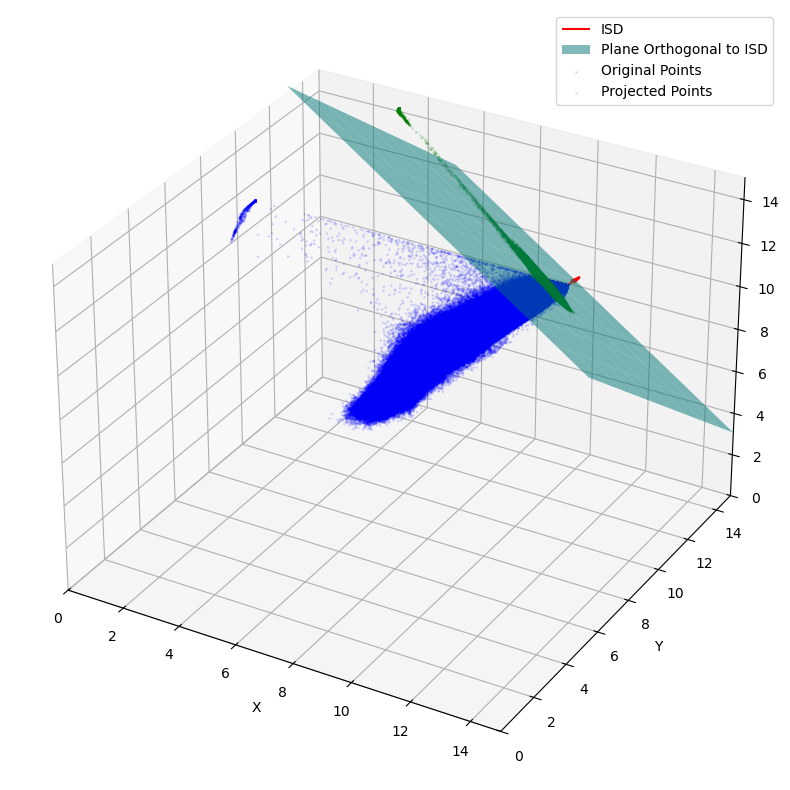

In [ ]:
plot_plane_orthogonal_to_isd(mean_isd, original_img = (img / 65535), img = log_img, projection = projected_log_rgb)

In [ ]:
projected_log_img_copy = projected_log_rgb.copy()
projected_log_img_converted = (np.exp(projected_log_img_copy)) / 256

In [ ]:
projected_img_converted = projected_log_img_converted.astype(np.uint8)

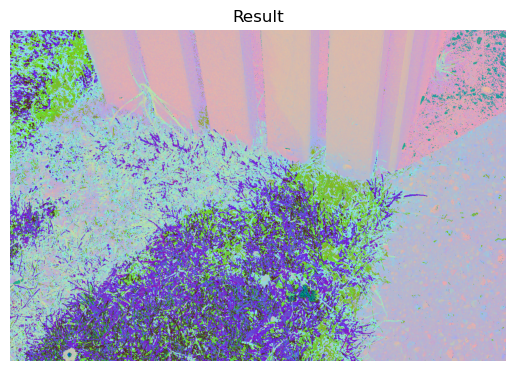

In [ ]:
display_image(projected_img_converted, "Result")

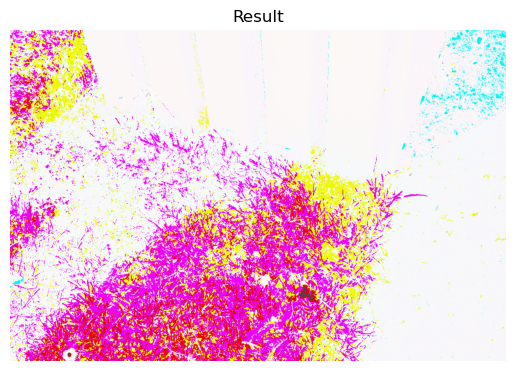

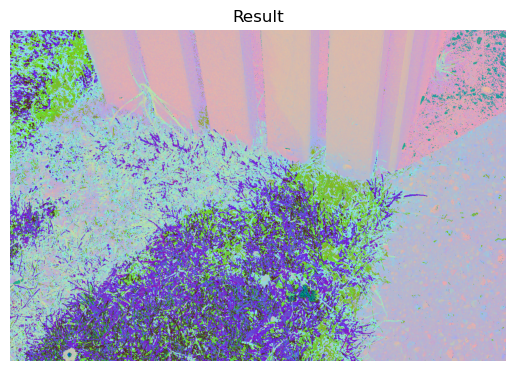

In [ ]:
def convert_log_rgb(img:np.array) -> np.array:
    """  
    Converts log img to rgb img
    """
    result = img * 256 / np.log(65535)
    result = result.astype(np.uint8)
    return result

def convert_log_projected_to_rbg(img:np.array) -> np.array:
    """ 
    Converts projected log to rbg img
    """
    result =  (np.exp(projected_log_img_copy)) / 256
    result = result.astype(np.uint8)
    return result

result = convert_log_rgb(projected_log_rgb)
result_2 = convert_log_projected_to_rbg(projected_log_rgb)
display_image(result, "Result")
display_image(result_2, "Result")

___
### Results

In [ ]:
# fig, axes = plt.subplots(2,2, figsize = (15, 10))
# ax = axes.ravel()
# ax[0].imshow(img)
# ax[0].axis("off")
# ax[0].set_title("Original")
# ax[1].imshow(chromaticity_image)
# ax[1].axis("off")
# ax[1].set_title("Standard Chromoaticity")
# ax[2].imshow(standard_log_chromaticity_image)
# ax[2].axis("off")
# ax[2].set_title("Log Chromoaticity")
# ax[3].imshow(projected_log_chromaticity_image)
# ax[3].axis("off")
# ax[3].set_title("Projected Log RBG")
# plt.savefig(str(FIGS_PATH) + "/" + img_file.strip(".tif") + "_PROCESSED.png")

In [2]:
import os

def count_files_in_folder(folder_path):
    return len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

folder_path = "/Users/nelsonfarrell/Documents/Northeastern/7180/projects/spectral_ratio/data/folder_1/processed/duplicates"
file_count = count_files_in_folder(folder_path)
print(f"Number of files in the folder: {file_count}")



Number of files in the folder: 102


In [9]:
import xml.etree.ElementTree as ET
from io import StringIO

def read_problematic_xml(xml_string):
    """
    Read XML with multiple annotation tags by wrapping them in a root element.
    
    Args:
        xml_string (str): The XML content as a string
    
    Returns:
        list: List of image annotations with their click data
    """
    # First, fix the XML by properly wrapping all annotations in a root element
    # Remove the existing dataset tags if present
    xml_string = xml_string.replace('<?xml version=\'1.0\' encoding=\'UTF-8\'?>\n', '')
    xml_string = xml_string.replace('<dataset>', '').replace('</dataset>', '')
    
    # Wrap everything in a proper root element
    fixed_xml = f'<?xml version="1.0" encoding="UTF-8"?>\n<root>\n{xml_string}</root>'
    
    # Parse the fixed XML
    tree = ET.parse(StringIO(fixed_xml))
    root = tree.getroot()
    
    # Extract data from each image
    images_data = []
    for annotation in root.findall('.//image'):
        image_data = {
            'name': annotation.get('name'),
            'target_directory': annotation.get('target_directory'),
            'patch_size': annotation.get('patch_size'),
            'anchor_point': annotation.get('anchor_point'),
            'clicks': []
        }
        
        # Get all clicks for this image
        for click in annotation.findall('click'):
            click_data = {
                'id': click.get('id'),
                'lit': {
                    'row': int(click.find('lit').get('row')),
                    'col': int(click.find('lit').get('col'))
                },
                'shadow': {
                    'row': int(click.find('shadow').get('row')),
                    'col': int(click.find('shadow').get('col'))
                }
            }
            image_data['clicks'].append(click_data)
        
        images_data.append(image_data)
    
    return images_data

with open('/Users/nelsonfarrell/Documents/Northeastern/7180/projects/spectral_ratio/annotations_test.xml', 'r') as f:
    xml_content = f.read()
    
images_data = read_problematic_xml(xml_content)

# Access the data
for image in images_data:
    print(f"Image: {image['name']}")
    print(f"Directory: {image['target_directory']}")
    print(f"Number of clicks: {len(image['clicks'])}")

Image: kasturi_tejasri_080.tif
Directory: data/folder_1/processed/low_quality
Number of clicks: 7
Image: kasturi_tejasri_094.tif
Directory: data/folder_1/processed/high_quality
Number of clicks: 5
Image: balasubramanian_aadhiaadhavan_037.tif
Directory: data/folder_1/processed/high_quality
Number of clicks: 2
Image: balasubramanian_aadhiaadhavan_023.tif
Directory: data/folder_1/processed/high_quality
Number of clicks: 8
Image: balasubramanian_aadhiaadhavan_022.tif
Directory: data/folder_1/processed/low_quality
Number of clicks: 11
Image: balasubramanian_aadhiaadhavan_036.tif
Directory: data/folder_1/processed/low_quality
Number of clicks: 6
Image: kasturi_tejasri_095.tif
Directory: data/folder_1/processed/high_quality
Number of clicks: 10
Image: kasturi_tejasri_081.tif
Directory: data/folder_1/processed/high_quality
Number of clicks: 3
Image: kasturi_tejasri_056.tif
Directory: data/folder_1/bad_images
Number of clicks: 1
Image: kasturi_tejasri_042.tif
Directory: data/folder_1/processed/

In [14]:
import xml.etree.ElementTree as ET

# Load and parse the XML file
tree = ET.parse('/Users/nelsonfarrell/Documents/Northeastern/7180/projects/spectral_ratio/annotations_test.xml')
root = tree.getroot()

# To find a specific image by name, you need to:
# 1. Search within annotations/image tags
# 2. Use the [@name='...'] syntax to match the name attribute

# Example finding one specific image
target_name = "kasturi_tejasri_080.tif"
image = root.find(".//image[@name='{}']".format(target_name))

if image is not None:
    print(f"Found image: {image.get('name')}")
    print(f"Target directory: {image.get('target_directory')}")
    # Get all clicks for this image
    for click in image.findall('click'):
        lit = click.find('lit')
        shadow = click.find('shadow')
        print(f"Click {click.get('id')}:")
        print(f"  Lit: row={lit.get('row')}, col={lit.get('col')}")
        print(f"  Shadow: row={shadow.get('row')}, col={shadow.get('col')}")
else:
    print(f"Image {target_name} not found")

# To find all images:
all_images = root.findall(".//image")
for img in all_images:
    print(f"Image name: {img.get('name')}")


Found image: kasturi_tejasri_080.tif
Target directory: data/folder_1/processed/low_quality
Click 1:
  Lit: row=202, col=731
  Shadow: row=357, col=802
Click 2:
  Lit: row=159, col=894
  Shadow: row=263, col=896
Click 3:
  Lit: row=157, col=776
  Shadow: row=403, col=810
Click 4:
  Lit: row=748, col=632
  Shadow: row=724, col=433
Click 5:
  Lit: row=769, col=637
  Shadow: row=756, col=416
Click 6:
  Lit: row=1170, col=222
  Shadow: row=1052, col=53
Click 7:
  Lit: row=1206, col=197
  Shadow: row=1075, col=33
Image name: kasturi_tejasri_080.tif
Image name: kasturi_tejasri_094.tif
Image name: balasubramanian_aadhiaadhavan_037.tif
Image name: balasubramanian_aadhiaadhavan_023.tif
Image name: balasubramanian_aadhiaadhavan_022.tif
Image name: balasubramanian_aadhiaadhavan_036.tif
Image name: kasturi_tejasri_095.tif
Image name: kasturi_tejasri_081.tif
Image name: kasturi_tejasri_056.tif
Image name: kasturi_tejasri_042.tif
Image name: adari_girish_018.tif
Image name: adari_girish_024.tif
Image

In [2]:
import os

def count_files_in_directory(directory):
    # List all files and count only those that are files
    return sum(1 for entry in os.listdir(directory) if os.path.isfile(os.path.join(directory, entry)))

# Example usage
directory_path = "/Users/nelsonfarrell/Documents/Northeastern/7180/projects/spectral_ratio/data/folder_3/processed_folder_3/isd_maps"
file_count = count_files_in_directory(directory_path)
print(f"Total files in '{directory_path}': {file_count}")


Total files in '/Users/nelsonfarrell/Documents/Northeastern/7180/projects/spectral_ratio/data/folder_3/processed_folder_3/isd_maps': 219


In [14]:
import numpy as np
print(np.unique(img))

[0.         0.00392157]
